In [178]:
import numpy as np
import pandas as pd

from nltk.tokenize import RegexpTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from pandas_profiling import ProfileReport
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args, dump
from skopt.plots import plot_objective, plot_histogram, plot_convergence,plot_evaluations, plot_regret
from functools import partial
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import sys
import time
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [120]:
df = pd.read_csv('../goodreads_train.csv')

In [121]:
df.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [122]:
df.dtypes

user_id         object
book_id          int64
review_id       object
rating           int64
review_text     object
date_added      object
date_updated    object
read_at         object
started_at      object
n_votes          int64
n_comments       int64
dtype: object

In [123]:
df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [124]:
# df['policy_application_date'] = pd.to_datetime(df.policy_application_date, format='%d-%b-%y', errors='ignore').head()
# df['policy_application_date_year'] = df.policy_application_date.apply(lambda x:x.year)
# # df['policy_effective_date_year'] = df['policy_effective_date_year'].astype(int)

# df.policy_application_date.dtypes, df.policy_application_date.head().tolist(), \
#     df.policy_application_date_year.dtypes, df.policy_application_date_year.unique()

### add new var: year of review

In [125]:
#df[df['added_dte'].Na()].count()
df['added_dte_trim'] = df['date_added'].str.replace('-0700', '', 1)
df['added_dte_trim'] = df['added_dte_trim'].str.replace('-0800', '', 1)
df['added_dte'] = pd.to_datetime(df['added_dte_trim'], format='%a %b %d %H:%M:%S %Y')

#df['policy_effective_date_year'] = df['added_dte_year'].astype(int)

In [126]:
df['added_dte_year'] = df['added_dte'].dt.year.astype(int)

In [127]:
df_fin = df[df['added_dte_year']!=2016]

### add new var: number of reviews from user

In [128]:
df['num_of_revs'] = df.groupby("user_id")["user_id"].transform('count')

In [129]:
df['avg_rv_user'] = df.groupby('user_id')['rating'].transform('mean')

In [130]:
df.head(100)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,added_dte_trim,added_dte,added_dte_year,num_of_revs,avg_rv_user
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,Sun Jul 30 07:44:10 2017,2017-07-30 07:44:10,2017,83,4.084337
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0,Mon Dec 05 10:46:44 2016,2016-12-05 10:46:44,2016,83,4.084337
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,Tue Nov 15 11:29:22 2016,2016-11-15 11:29:22,2016,83,4.084337
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1,Wed Nov 09 17:37:04 2016,2016-11-09 17:37:04,2016,83,4.084337
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1,Mon Apr 25 09:31:23 2016,2016-04-25 09:31:23,2016,83,4.084337
5,8842281e1d1347389f2ab93d60773d4d,19398490,ea4a220b10e6b5c796dae0e3b970aff1,4,A beautiful story. It is rare to encounter a b...,Sun Jan 03 21:20:46 -0800 2016,Tue Sep 20 23:30:15 -0700 2016,Tue Sep 13 11:51:51 -0700 2016,Sat Aug 20 07:03:03 -0700 2016,35,5,Sun Jan 03 21:20:46 2016,2016-01-03 21:20:46,2016,83,4.084337
6,8842281e1d1347389f2ab93d60773d4d,22318578,5fe9882bfe4b0520a322820c4c55747d,5,5 stars for giving me a better framework for h...,Sun Jun 07 12:50:13 -0700 2015,Wed Mar 22 11:36:58 -0700 2017,Sun Aug 09 00:00:00 -0700 2015,Sun Jun 07 00:00:00 -0700 2015,24,3,Sun Jun 07 12:50:13 2015,2015-06-07 12:50:13,2015,83,4.084337
7,8842281e1d1347389f2ab93d60773d4d,24189224,dbc01e2438df7a87ee3dc16ee23a53e5,0,Numerous people in publishing have told me thi...,Fri May 29 17:48:57 -0700 2015,Fri May 29 17:49:40 -0700 2015,NaN,NaN,11,5,Fri May 29 17:48:57 2015,2015-05-29 17:48:57,2015,83,4.084337
8,8842281e1d1347389f2ab93d60773d4d,22551730,754710070f38e1c59a45f6a85473b836,4,Another hard to put down nonfiction book from ...,Thu May 07 13:59:32 -0700 2015,Wed Dec 14 12:30:43 -0800 2016,Sat Jul 11 00:00:00 -0700 2015,Wed Jun 24 00:00:00 -0700 2015,20,6,Thu May 07 13:59:32 2015,2015-05-07 13:59:32,2015,83,4.084337
9,8842281e1d1347389f2ab93d60773d4d,22816087,d11954e6e9e9ddf52aed41d83ce43fa6,5,I love Stephenson - and this was another hit -...,Wed Apr 29 10:56:44 -0700 2015,Wed Dec 14 12:30:43 -0800 2016,Wed Nov 04 00:00:00 -0800 2015,Sun Sep 27 00:00:00 -0700 2015,40,6,Wed Apr 29 10:56:44 2015,2015-04-29 10:56:44,2015,83,4.084337


In [131]:
df.dtypes

user_id                   object
book_id                    int64
review_id                 object
rating                     int64
review_text               object
date_added                object
date_updated              object
read_at                   object
started_at                object
n_votes                    int64
n_comments                 int64
added_dte_trim            object
added_dte         datetime64[ns]
added_dte_year             int64
num_of_revs                int64
avg_rv_user              float64
dtype: object

In [132]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

numerical =['n_votes','n_comments','added_dte_year','num_of_revs','avg_rv_user']

df['review_text_new'] = df['review_text'].astype('U')
X = df[['review_text_new'] + numerical]
#X = df['review_text_new']
y = df['rating'].astype('U')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

In [173]:
%%time
#https://towardsdatascience.com/featureunion-columntransformer-pipeline-for-preprocessing-text-data-9dcb233dbcb6

class CharacterCounter(BaseEstimator, TransformerMixin):
    """Count the number of characters in a document."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        n_characters = X.str.len()
        return n_characters.values.reshape(-1,1) # 2D array
    
class TokenCounter(BaseEstimator, TransformerMixin):
    """Count the number of tokens in a document."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.tokeniser = RegexpTokenizer(r'[A-Za-z]+')
        return self
    
    def transform(self, X):
        n_tokens = X.apply(lambda document: len(self.tokeniser.tokenize(document)))
        return n_tokens.values.reshape(-1,1) # 2D array

# Build a FeatureUnion
text = 'review_text_new'

vectoriser = TfidfVectorizer(lowercase = True,stop_words = 'english',analyzer = 'word',max_features=50)
#character_counter = CharacterCounter()

preprocessor = FeatureUnion([
    ('vectoriser', vectoriser),
    ('character_counter', character_counter),
])

#preprocessor.fit(X_train[text])

# # Transform the data and format for readibility
#columns = preprocessor.transformer_list[0][1].get_feature_names() + ['n_characters']
#X_train_transformed = pd.DataFrame(preprocessor.transform(X_train[text]).toarray(), columns=columns)
# X_train_transformed

CPU times: user 62 µs, sys: 1e+03 ns, total: 63 µs
Wall time: 70.1 µs


In [186]:
%%time
#https://towardsdatascience.com/featureunion-columntransformer-pipeline-for-preprocessing-text-data-9dcb233dbcb6

class CharacterCounter(BaseEstimator, TransformerMixin):
    """Count the number of characters in a document."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        n_characters = X.str.len()
        return n_characters.values.reshape(-1,1) # 2D array
    
class TokenCounter(BaseEstimator, TransformerMixin):
    """Count the number of tokens in a document."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.tokeniser = RegexpTokenizer(r'[A-Za-z]+')
        return self
    
    def transform(self, X):
        n_tokens = X.apply(lambda document: len(self.tokeniser.tokenize(document)))
        return n_tokens.values.reshape(-1,1) # 2D array

# Build a FeatureUnion
text = 'review_text_new'

vectoriser = TfidfVectorizer(lowercase = True,stop_words = 'english',analyzer = 'word',max_features=50)
counter_pipe = Pipeline([
    ('character_counter', CharacterCounter()),
])

#moved upward!
numerical = ['n_votes','n_comments','added_dte_year','num_of_revs','avg_rv_user']

text_union = FeatureUnion([
    ('vectoriser', vectoriser),
    ('counter', counter_pipe)
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('text', text_union, text)
])

preprocessor.fit(X_train)

# Transform the data and format for readibility
terms = preprocessor.named_transformers_['text'].transformer_list[0][1].get_feature_names()
columns = numerical + terms + ['n_characters']
#print(columns)
X_traint = pd.DataFrame(preprocessor.transform(X_train).toarray(), columns=columns)
#X_train_transformed

/data/acajupyter/anaconda3/envs/server1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
X_traint.head()

In [ ]:
%%time
#Attempt 2 - RF
#pipe = Pipeline([('naive_bayes', MultinomialNB())])

from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       #('naive_bayes', MultinomialNB()) ])
                      ('classifier', RandomForestClassifier())])
                     
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipe.fit(X_train, list(y_train))


y_pred = pipe.predict(X_val)
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))
plt.imshow(confusion_matrix(y_pred, y_val))

In [ ]:
#Attmpt 2 - RandomForest
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

[[  716   228   310   547   780   668]
 [  165   237   331   482   681   521]
 [  249   461  1157  2117  2651  1914]
 [ 1079  1363  3800  9890 14123  9395]
 [ 1539  1607  4362 13007 22673 18190]
 [ 1362   983  2245  5796 12078 14396]]
0.32260376192448537
CPU times: user 1h 12min 26s, sys: 11min 19s, total: 1h 23min 46s
Wall time: 1h 24min 16s


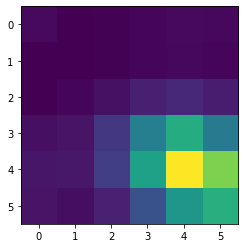

In [67]:
%%time
#attmpt 3 knn = KNeighborsClassifier()

#pipe = Pipeline([('naive_bayes', MultinomialNB())])

from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       #('naive_bayes', MultinomialNB()) ])
                      ('classifier', KNeighborsClassifier())])
                     
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipe.fit(X_train, list(y_train))


y_pred = pipe.predict(X_val)
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))
plt.imshow(confusion_matrix(y_pred, y_val))

/data/acajupyter/anaconda3/envs/server1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


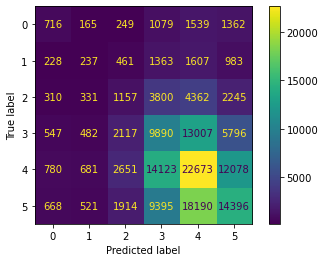

In [68]:
#Attmpt 3 - Kneighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

[[  155    47    90   185   359   401]
 [    0    18    27    23    22    18]
 [    0     0     2     0     0     0]
 [   38    80   277   433   154    30]
 [ 5250  4672 12599 33760 51883 35023]
 [  755   927  1530  3393 10320 17529]]
0.389
CPU times: user 1min 8s, sys: 2.75 s, total: 1min 11s
Wall time: 1min 6s


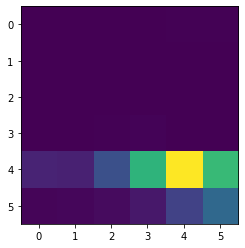

In [187]:
%%time
#attmpt 1 - NB

#pipe = Pipeline([('naive_bayes', MultinomialNB())])

from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('naive_bayes', MultinomialNB()) ])
              
                     
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipe.fit(X_train, list(y_train))


y_pred = pipe.predict(X_val)
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))
plt.imshow(confusion_matrix(y_pred, y_val))

/data/acajupyter/anaconda3/envs/server1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


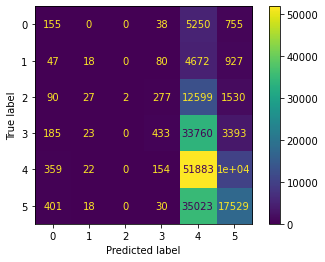

In [188]:
#Attmpt 1 - Kneighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

In [103]:
cm = confusion_matrix(y_pred, y_val)

In [104]:
cm[4,3]

31717

In [105]:
y_val

array([5, 4, 4, ..., 2, 5, 4])

In [106]:
invest = pd.concat([pd.DataFrame(X_val), pd.DataFrame(y_pred), pd.DataFrame(y_val)], axis = 1)

In [107]:
invest.columns = ['review_text_new','n_votes','n_comments','added_dte_year','num_of_revs','pred','actual']

ValueError: Length mismatch: Expected axis has 8 elements, new values have 7 elements

In [ ]:
look = invest[(invest['pred']==4.0) & (invest['actual']==3.0)]

In [108]:
look.head(3000)

,review_text_new,n_votes,n_comments,added_dte_year,num_of_revs,pred,actual
43269,"3.75 stars \n This was a light, fun read with ...",0.0,0.0,2013.0,166.0,4.0,3.0
123626,This is the third installment of the Jane Yell...,0.0,0.0,2011.0,263.0,4.0,3.0
117656,"Maybe 3.5? It wasn't amazing, but it was a fun...",2.0,0.0,2015.0,309.0,4.0,3.0
91630,This is a book that knows what it is. I had re...,0.0,0.0,2017.0,42.0,4.0,3.0
101567,I couldn't have asked for a better ending to t...,0.0,0.0,2014.0,196.0,4.0,3.0
139090,"OK, I feel a little bit lonely writing this re...",2.0,4.0,2014.0,11.0,4.0,3.0
74197,I have loved every book I've read by JoJo Moye...,0.0,0.0,2015.0,283.0,4.0,3.0
62710,"Now I do love all Pendergast books, and yes so...",0.0,0.0,2014.0,51.0,4.0,3.0
19428,"I loved this one, slow build at its best! Defi...",1.0,0.0,2016.0,241.0,4.0,3.0
104250,After King Cole's rather silly shenanigans in ...,0.0,0.0,2012.0,215.0,4.0,3.0


In [ ]:
#Attmpt 1 - NB
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

In [ ]:
df_test.to_csv('submission.csv',columns = ['review_id', 'rating'],
               header = ['review_id', 'rating'], index = False)

In [23]:
df_sample = df.sample(frac = 0.3)
df_sample['rating'].value_counts()

4    93780
5    79566
3    56794
2    22002
0     9214
1     8644
Name: rating, dtype: int64